In [1]:
import os
import pickle
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GRU, Dense 
print('TensorFlow',tf.__version__)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

TensorFlow 1.13.1


In [2]:
NUM_SAMPLES = 250000
dataset = tfds.load(name='wmt_translate_enfr', as_supervised=True)
dataset['train'] = dataset['train'].take(NUM_SAMPLES)

In [3]:
en_sentences = []
fr_sentences = []
for example in tqdm(dataset['train']):
    en_sentences.append(example[0].numpy().decode())
    fr_sentences.append('startseq ' + example[1].numpy().decode() + ' endseq')
for example in tqdm(dataset['validation']):
    en_sentences.append(example[0].numpy().decode())
    fr_sentences.append('startseq ' + example[1].numpy().decode() + ' endseq')    

250000it [00:18, 13493.15it/s]
1000it [00:00, 11552.14it/s]


In [4]:
en_tk = Tokenizer(num_words=20000)
fr_tk = Tokenizer(num_words=20000)

with open('en.pkl', 'wb') as f:
    pickle.dump(en_tk, f)

with open('fr.pkl', 'wb') as f:
    pickle.dump(fr_tk, f)
    
en_tk.fit_on_texts(en_sentences)
fr_tk.fit_on_texts(fr_sentences)    

In [5]:
with open('en.pkl', 'rb') as f:
    en_tk = pickle.load( f)

with open('fr.pkl', 'rb') as f:
    fr_tk = pickle.load(f)

English sentences : mean = 18.157609561752988, std = 9.575238019518183, max = 156
French sentences : mean = 21.158717131474102, std = 10.117183722841965, max = 207


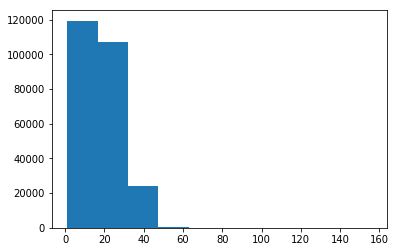

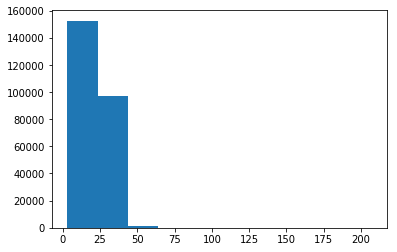

In [6]:
en_lens = [len(x.split()) for x in en_sentences]
fr_lens = [len(x.split()) for x in fr_sentences]

plt.figure()
plt.hist(en_lens)

plt.figure()
plt.hist(fr_lens)

en_mean = np.mean(en_lens)
en_std = np.std(en_lens)
fr_mean = np.mean(fr_lens)
fr_std = np.std(fr_lens)
en_max = np.max(en_lens)
fr_max = np.max(fr_lens)

print(f'English sentences : mean = {en_mean}, std = {en_std}, max = {en_max}')
print(f'French sentences : mean = {fr_mean}, std = {fr_std}, max = {fr_max}')

In [7]:
max_sequence_len = 30
en_vocab_size = 20000
fr_vocab_size =20000

In [8]:
def preprocess_en(en):
    encoded_en = en_tk.texts_to_sequences(en)
    padded_en = pad_sequences(encoded_en, maxlen=max_sequence_len, padding='post', truncating='post')
    return padded_en

def preprocess_fr(fr):
    encoded_fr = fr_tk.texts_to_sequences(fr)
    padded_fr = pad_sequences(encoded_fr, maxlen=max_sequence_len, padding='post', truncating='post')
    return padded_fr

def preprocess_text(en, fr):
    return preprocess_en(en.numpy().decode()), preprocess_fr(fr.numpy().decode())

In [9]:
train_ds = dataset['train']
train_en = []
train_fr = []
for example in tqdm(train_ds):
    train_en.append(example[0].numpy().decode())
    train_fr.append('startseq ' + example[1].numpy().decode() + ' endseq')
train_en = preprocess_en(train_en)
train_fr = preprocess_fr(train_fr)

250000it [00:18, 13374.83it/s]


In [7]:
batch_size = 64

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_en, train_fr))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(1024)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
class Encoder(tf.keras.Model):
    def __init__(self, hidden_size=1024, max_sequence_len=30, batch_size=batch_size, embedding_dim=256, vocab_size=20000):
        super(Encoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.max_sequence_len = max_sequence_len
        self.hidden_size = hidden_size
        self.batch_size = batch_size

        self.embedding_layer = Embedding(
            input_dim=self.vocab_size, output_dim=self.embedding_dim)
        self.GRU_1 = GRU(units=hidden_size, return_sequences=True)
        self.GRU_2 = GRU(units=hidden_size,
                         return_sequences=True, return_state=True)

    def initial_hidden_state(self):
        return tf.zeros(shape=(self.batch_size, self.hidden_size))

    def call(self, x, initial_state, training=False):
        x = self.embedding_layer(x)
        x = self.GRU_1(x, initial_state=initial_state)
        x, hidden_state = self.GRU_2(x)
        return x, hidden_state


class Attention(tf.keras.Model):
    def __init__(self, hidden_size=256):
        super(Attention, self).__init__()
        self.fc1 = Dense(units=hidden_size)
        self.fc2 = Dense(units=hidden_size)
        self.fc3 = Dense(units=1)

    def call(self, encoder_output, hidden_state, training=False):
        '''hidden_state : h(t-1)'''
        y_hidden_state = tf.expand_dims(hidden_state, axis=1)
        y_hidden_state = self.fc1(y_hidden_state)
        y_enc_out = self.fc2(encoder_output)

        y = tf.keras.backend.tanh(y_enc_out + y_hidden_state)
        attention_score = self.fc3(y)
        attention_weights = tf.keras.backend.softmax(attention_score, axis=1)

        context_vector = tf.multiply(encoder_output, attention_weights)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


class Decoder(tf.keras.Model):
    def __init__(self, hidden_size=1024, max_sequence_len=30, batch_size=batch_size, embedding_dim=256, vocab_size=20000):
        super(Decoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.max_sequence_len = max_sequence_len
        self.hidden_size = hidden_size
        self.batch_size = batch_size
    
        self.embedding_layer = Embedding(
            input_dim=self.vocab_size, output_dim=self.embedding_dim)
        self.GRU = GRU(units=hidden_size,
                       return_sequences=True, return_state=True)
        self.attention = Attention(hidden_size=self.hidden_size)
        self.fc = Dense(units=self.vocab_size)

    def initial_hidden_state(self):
        return tf.zeros(shape=(self.batch_size, self.hidden_size))

    def call(self, x, encoder_output, hidden_state, training=False):
        x = self.embedding_layer(x)
        context_vector, attention_weights = self.attention(
            encoder_output, hidden_state, training=training)
        contect_vector = tf.expand_dims(context_vector, axis=1)
        x = tf.concat([x, contect_vector], axis=-1)
        x, curr_hidden_state = self.GRU(x)
        x = tf.reshape(x, shape=[self.batch_size, -1])
        x = self.fc(x)
        return x, curr_hidden_state, attention_weights

In [ ]:
loss_object = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
train_accuracy = tf.metrics.SparseCategoricalAccuracy()


def loss_function(y_true, y_pred):
    loss = loss_object(y_true, y_pred)
    mask = 1 - tf.cast(tf.equal(y_true, 0), 'float32')
    return tf.reduce_mean(loss * mask)
    
@tf.function()
def training_step(en, fr):    
    with tf.GradientTape() as Tape:
        encoder_init_state = encoder.initial_hidden_state()
        encoder_output, encoder_hidden_state = encoder(en, encoder_init_state, training=True)
        decoder_hidden = encoder_hidden_state
        loss = 0
        acc = []
        current_word = tf.expand_dims(fr[:, 0], axis=1)
        for word_idx in range(1, max_sequence_len):
            next_word = fr[:, word_idx]
            logits, decoder_hidden, attention_weights = decoder(current_word, encoder_output, decoder_hidden, training=True)
            loss += loss_function(next_word, logits)
            acc.append(train_accuracy(next_word, logits))
            current_word = tf.expand_dims(next_word, axis=1)
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = Tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss, tf.reduce_mean(acc)

In [ ]:
encoder = Encoder()
decoder = Decoder()
checkpoint_dir = 'training'
checkpoint_prefix = 'training/ckpt'
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [14]:
epochs = 6
num_steps = NUM_SAMPLES // batch_size
for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}/{epochs}')
    ep_loss = []
    ep_acc = []
    progbar = tf.keras.utils.Progbar(target=num_steps, stateful_metrics=[
                                     'curr_loss', 'curr_accuracy'], unit_name='batch')

    for step, example in enumerate(train_dataset):
        en = example[0]
        fr = example[1]
        loss, acc = training_step(en, fr)
        loss /= fr.shape[1]
        ep_loss.append(loss)
        ep_acc.append(acc)
        progbar.update(
            step + 1, values=[('curr_loss', loss), ('curr_accuracy', acc)])

    if epoch % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
    print(f'Metrics after epoch {epoch} : Loss => {np.mean(ep_loss):.3f} | Accuracy => {np.mean(ep_acc):.3f}')
checkpoint.save(file_prefix=checkpoint_prefix)

Epoch 1/6
3906/3906 [==============================] - 1052s 269ms/batch - curr_loss: 1.9113 - curr_accuracy: 0.4873
Metrics after epoch 1 : Loss => 2.350 | Accuracy => 0.433
Epoch 2/6
3906/3906 [==============================] - 1033s 264ms/batch - curr_loss: 1.4520 - curr_accuracy: 0.5449
Metrics after epoch 2 : Loss => 1.602 | Accuracy => 0.518
Epoch 3/6
3906/3906 [==============================] - 1033s 264ms/batch - curr_loss: 1.2773 - curr_accuracy: 0.5778
Metrics after epoch 3 : Loss => 1.352 | Accuracy => 0.562
Epoch 4/6
3906/3906 [==============================] - 1035s 265ms/batch - curr_loss: 1.1742 - curr_accuracy: 0.6002
Metrics after epoch 4 : Loss => 1.210 | Accuracy => 0.590
Epoch 5/6
3906/3906 [==============================] - 1033s 265ms/batch - curr_loss: 1.0600 - curr_accuracy: 0.6173
Metrics after epoch 5 : Loss => 1.102 | Accuracy => 0.609
Epoch 6/6
3906/3906 [==============================] - 1033s 264ms/batch - curr_loss: 1.0080 - curr_accuracy: 0.6308
Metrics 

In [ ]:
checkpoint.restore('training/ckpt-4')

In [195]:
for example in dataset['validation'].take(8):
    print(example[0].numpy().decode())
    print(example[1].numpy().decode())
    print('-'*30)

What more do you want?
Que voulez-vous de plus ?
------------------------------
It’s designed like an Escher print.
Elle est dessinée comme une gravure d’Escher.
------------------------------
You are very pretty in those clothes.
Tu es très belle avec ces vêtements.
------------------------------
I am in favour of this, but we must recognise that basically this has come to be equated with the Growth and Stability Pact. I am sure you will confirm this.
Je suis pour, mais il faut reconnaître qu'elle s'est foncièrement alignée sur le Pacte de stabilité, et vous le confirmez.
------------------------------
There must be a misunderstanding.
Il doit y avoir un malentendu.
------------------------------
We must not do this in an imposing manner but in a way that will reassure these citizens that Europe will actively support social stability, economic prosperity and freedom within their respective regions.
Nous ne devons rien imposer, mais agir d'une façon qui va rassurer ces citoyens quant à

In [121]:
def translate_sentence(sentence):
    sentence = preprocess_en([sentence])
    enc_init = tf.zeros(shape=[1, 1024])
    enc_out, enc_hidden = encoder(sentence, enc_init)

    decoder.batch_size = 1
    fr_tk.index_word[0] = ''
    decoded = []
    att = []
    current_word = tf.expand_dims([fr_tk.word_index['startseq']], axis=0) 
    decoder_hidden = enc_hidden
    for word_idx in range(1, max_sequence_len):
        logits, decoder_hidden, attention_weights = decoder(current_word, enc_out, decoder_hidden)
        decoded_idx = np.argmax(logits)
        if fr_tk.index_word[decoded_idx] == 'endseq':
            break
        decoded.append(fr_tk.index_word[decoded_idx])
        att.append(attention_weights.numpy().squeeze())
        current_word = tf.expand_dims([decoded_idx], axis=0)
    return ' '.join(decoded), att

EN :  There is a misunderstanding
FR :  il y a un malentendu
------------------------------
EN :  what do you want ?
FR :  que veux tu
------------------------------
EN :  are you mad ?
FR :  es tu fou
------------------------------
EN :  state of the art
FR :  l'état de l'art
------------------------------
EN :  the exam is going to be hard
FR :  l'examen est difficile
------------------------------
EN :  do you want to play with me ?
FR :  voulez vous jouer avec moi
------------------------------
EN :  i love you
FR :  je t'aime
------------------------------
EN :  how are you doing ?
FR :  comment allez vous
------------------------------
EN :  i should tell you that i am quite dangerous
FR :  je dois vous dire que je suis très dangereux
------------------------------
EN :  Do you have any idea of how to use it ?
FR :  as tu une idée de comment l'utiliser
------------------------------


<Figure size 288x360 with 0 Axes>

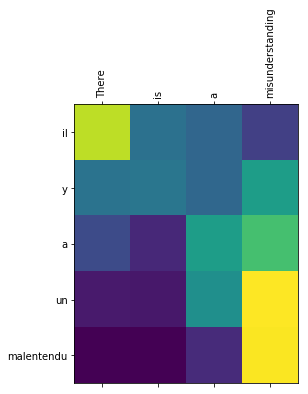

<Figure size 360x216 with 0 Axes>

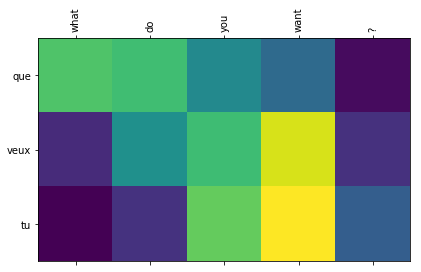

<Figure size 288x216 with 0 Axes>

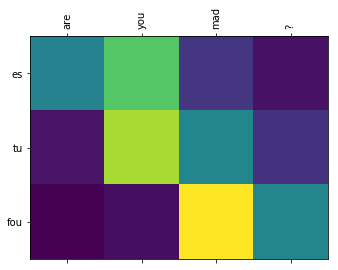

<Figure size 288x216 with 0 Axes>

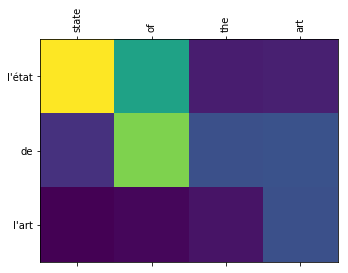

<Figure size 504x216 with 0 Axes>

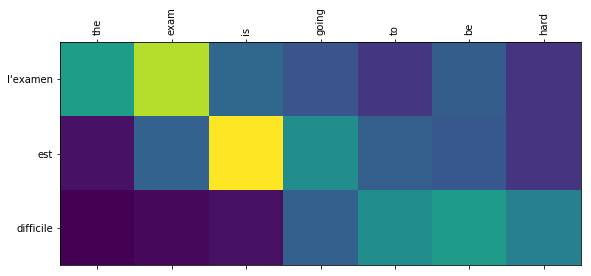

<Figure size 576x360 with 0 Axes>

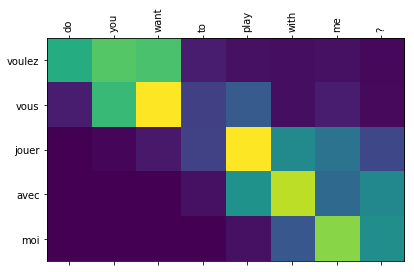

<Figure size 216x144 with 0 Axes>

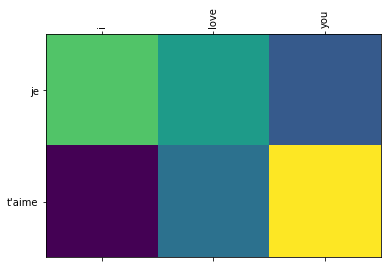

<Figure size 360x216 with 0 Axes>

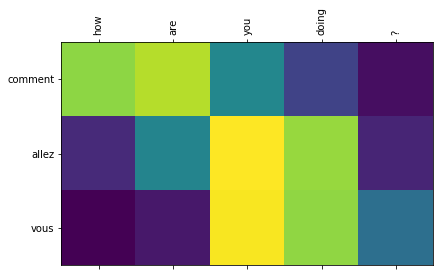

<Figure size 648x648 with 0 Axes>

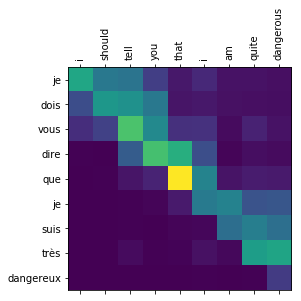

<Figure size 792x504 with 0 Axes>

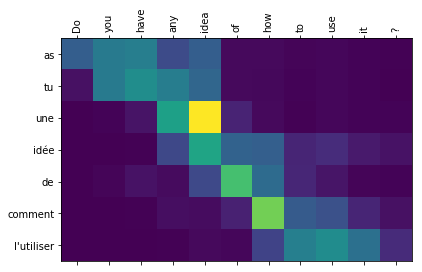

In [200]:
sentences = ['There is a misunderstanding',
             'what do you want ?',
             'are you mad ?',
             'state of the art',
             'the exam is going to be hard', 
             'do you want to play with me ?','i love you', 
             'how are you doing ?', 
             'i should tell you that i am quite dangerous', 
             'Do you have any idea of how to use it ?']

for inp_sentence in sentences:
    inp_array = inp_sentence.split()
    inp_len = len(inp_sentence.split())
    trans_sentence, attention_weights = translate_sentence(inp_sentence)
    trans_array = trans_sentence.split()
    trans_len = len(trans_array)
    attention_weights = np.array([x for x in attention_weights])
    attention_weights = attention_weights[:trans_len,:inp_len]
    plt.figure(figsize=(inp_len, trans_len))
    plt.matshow(attention_weights)
    plt.xticks(ticks=range(inp_len), labels=inp_array, rotation=90)
    plt.yticks(ticks=range(trans_len), labels=trans_array)
    print('EN : ', inp_sentence)
    print('FR : ', trans_sentence)
    print('-'*30)